# Анализ набора данных изображений российских дорожных знаков (RTSD)

Набор данных RTSD содержит кадры, предоставленные консалтинговой компанией Geocenter (http://geocenter-consulting.ru ). Кадры получены с широкоэкранного цифрового видеомагнитофона, который снимает 5 кадров в секунду. Разрешение кадра составляет от 1280 × 720 до 1920 × 1080. Кадры снимаются в разное время года (весна, осень, зима), в разное время суток (утро, день, вечер) и в разных погодных условиях (дождь, снег, яркое солнце). В наборе используется 155 знак дорожного движения, формат разметки - Common Objects in Context (COCO).

Файлы json состоят из 3 списков:

- images содержит информацию о изображениях (метаданные - id, ширина, высота и путь к файлу);

- annotations содержит информацию о аннотациях (ограничивающие прямоугольники, классы объектов и т.д.);

- categories содержит информацию о категориях классификации.

In [1]:
# !pip install kaggle
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !kaggle datasets download -d watchman/rtsd-dataset
# !unzip rtsd-dataset.zip
# !rm rtsd-dataset.zip
# !cp -r rtsd-frames/rtsd-frames/ .
# !rm -r rtsd-frames/rtsd-frames/

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# !pip install Cython
# !pip install fiftyone
# !pip install pycocotools

In [4]:
# библиотеки
import numpy as np
import pandas as pd
import os
import json
from PIL import Image
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import seaborn as sns
import random
import cv2
from pycocotools.coco import COCO
import fiftyone as fo

import warnings
warnings.filterwarnings('ignore')

In [5]:
%matplotlib inline

In [6]:
# !pip install git+https://github.com/gautamchitnis/cocoapi.git@cocodataset-master#subdirectory=PythonAPI

In [7]:
# Загрузим набор данных RTSD
with open(os.path.join('.', 'train_anno.json'), 'r') as f:
    train_anno = json.load(f)
train_anno.keys()

dict_keys(['images', 'annotations', 'categories'])

In [8]:
obj1 = train_anno.get('images')
df1 = pd.json_normalize(obj1)
df1

id  width  height                                      file_name
0          0   1280     720    rtsd-frames/autosave01_02_2012_09_13_33.jpg
1          1   1280     720    rtsd-frames/autosave01_02_2012_09_13_34.jpg
2          2   1280     720    rtsd-frames/autosave01_02_2012_09_13_35.jpg
3          3   1280     720    rtsd-frames/autosave01_02_2012_09_13_36.jpg
4          4   1280     720    rtsd-frames/autosave01_02_2012_09_13_37.jpg
...      ...    ...     ...                                            ...
54183  59183   1280     720  rtsd-frames/autosave24_10_2013_13_18_37_1.jpg
54184  59184   1280     720  rtsd-frames/autosave24_10_2013_13_18_37_2.jpg
54185  59185   1280     720  rtsd-frames/autosave24_10_2013_13_18_38_0.jpg
54186  59186   1280     720  rtsd-frames/autosave24_10_2013_13_18_38_1.jpg
54187  59187   1280     720  rtsd-frames/autosave24_10_2013_13_18_38_2.jpg

[54188 rows x 4 columns]

In [9]:
obj2 = train_anno.get('annotations')
df2 = pd.json_normalize(obj2)
df2

id  image_id  category_id  area                bbox  iscrowd
0           0         0            1   324  [649, 376, 18, 18]        0
1           1         1            1   420  [671, 356, 20, 21]        0
2           2         2            1   702  [711, 332, 27, 26]        0
3           3         3            1  1332  [764, 290, 37, 36]        0
4           4         3            2   289  [684, 384, 17, 17]        0
...       ...       ...          ...   ...                 ...      ...
95487  104353     59183          116   432  [622, 394, 27, 16]        0
95488  104354     59184          116   558  [638, 387, 31, 18]        0
95489  104355     59185          116   660  [647, 385, 33, 20]        0
95490  104356     59186          116   943  [668, 378, 41, 23]        0
95491  104357     59187          116  1196  [703, 370, 46, 26]        0

[95492 rows x 6 columns]

In [10]:
obj3 = train_anno.get('categories')
df3 = pd.json_normalize(obj3)
df3

id   name
0      1    2_1
1      2   1_23
2      3   1_17
3      4   3_24
4      5  8_2_1
..   ...    ...
150  151   1_10
151  152   8_16
152  153   7_18
153  154   7_14
154  155   8_23

[155 rows x 2 columns]

In [11]:
t1 = df2.merge(df3.set_index('id'), left_on='category_id',right_index=True)
t1

id  image_id  category_id   area                   bbox  iscrowd  \
0           0         0            1    324     [649, 376, 18, 18]        0   
1           1         1            1    420     [671, 356, 20, 21]        0   
2           2         2            1    702     [711, 332, 27, 26]        0   
3           3         3            1   1332     [764, 290, 37, 36]        0   
5           5         4            1   3192     [876, 200, 56, 57]        0   
...       ...       ...          ...    ...                    ...      ...   
93566  102243     57701          154   2340     [767, 306, 39, 60]        0   
93567  102245     57703          154  16912  [1143, 101, 112, 151]        0   
93720  102416     57822          155    612     [762, 367, 36, 17]        0   
93723  102419     57823          155   1456     [878, 346, 56, 26]        0   
93726  102422     57824          155   3648    [1203, 283, 76, 48]        0   

       name  
0       2_1  
1       2_1  
2       2_1  
3       2_1  
5       2_1  
...     ...  
93566  7_14  
93567  7_14  
93720  8_23  
93723  8_23  
93726  8_23  

[95492 rows x 7 columns]

In [12]:
t2= t1.merge(df1.set_index('id'), left_on='image_id',right_index=True)
t2

id  image_id  category_id   area                   bbox  iscrowd  \
0           0         0            1    324     [649, 376, 18, 18]        0   
1           1         1            1    420     [671, 356, 20, 21]        0   
2           2         2            1    702     [711, 332, 27, 26]        0   
3           3         3            1   1332     [764, 290, 37, 36]        0   
4           4         3            2    289     [684, 384, 17, 17]        0   
...       ...       ...          ...    ...                    ...      ...   
64600   70506     38149          149   2100    [1007, 307, 35, 60]        0   
64601   70507     38150          149   3150    [1088, 296, 45, 70]        0   
93565  102242     57700          154   1519     [712, 329, 31, 49]        0   
93566  102243     57701          154   2340     [767, 306, 39, 60]        0   
93567  102245     57703          154  16912  [1143, 101, 112, 151]        0   

        name  width  height                                      file_name  
0        2_1   1280     720    rtsd-frames/autosave01_02_2012_09_13_33.jpg  
1        2_1   1280     720    rtsd-frames/autosave01_02_2012_09_13_34.jpg  
2        2_1   1280     720    rtsd-frames/autosave01_02_2012_09_13_35.jpg  
3        2_1   1280     720    rtsd-frames/autosave01_02_2012_09_13_36.jpg  
4       1_23   1280     720    rtsd-frames/autosave01_02_2012_09_13_36.jpg  
...      ...    ...     ...                                            ...  
64600  6_8_1   1280     720  rtsd-frames/autosave16_10_2012_08_36_42_2.jpg  
64601  6_8_1   1280     720  rtsd-frames/autosave16_10_2012_08_36_43_0.jpg  
93565   7_14   1280     720  rtsd-frames/autosave24_10_2013_11_23_19_1.jpg  
93566   7_14   1280     720  rtsd-frames/autosave24_10_2013_11_23_19_2.jpg  
93567   7_14   1280     720  rtsd-frames/autosave24_10_2013_11_23_20_1.jpg  

[95492 rows x 10 columns]

In [13]:
# функция загрузки датасета в pd
def dataset(path, name_f):
  
  with open(os.path.join(path, name_f), 'r') as f:
    anno = json.load(f)

    obj1 = anno.get('images')
    df1 = pd.json_normalize(obj1)
    obj2 = anno.get('annotations')
    df2 = pd.json_normalize(obj2)
    obj3 = anno.get('categories')
    df3 = pd.json_normalize(obj3)
    t = df2.merge(df3.set_index('id'), left_on='category_id',right_index=True)
    df= t.merge(df1.set_index('id'), left_on='image_id',right_index=True)
  
  return df

In [14]:
df_train_anno = dataset('.', 'train_anno.json')

In [15]:
# посмотрим инфо по датасету
df_train_anno.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95492 entries, 0 to 93567
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           95492 non-null  int64 
 1   image_id     95492 non-null  int64 
 2   category_id  95492 non-null  int64 
 3   area         95492 non-null  int64 
 4   bbox         95492 non-null  object
 5   iscrowd      95492 non-null  int64 
 6   name         95492 non-null  object
 7   width        95492 non-null  int64 
 8   height       95492 non-null  int64 
 9   file_name    95492 non-null  object
dtypes: int64(7), object(3)
memory usage: 8.0+ MB


In [16]:
pd.DataFrame(df_train_anno['name'].value_counts()).reset_index()

index   name
0    5_19_1  22147
1       2_1  10027
2      5_16   4727
3    5_15_2   4504
4      3_24   3761
..      ...    ...
150    8_23      3
151   8_3_3      2
152     4_5      2
153    3_33      1
154   2_3_5      1

[155 rows x 2 columns]

In [17]:
df_train_anno.groupby('file_name', as_index=False).agg(list)

file_name        id image_id  \
0        rtsd-frames/autosave01_02_2012_09_13_33.jpg       [0]      [0]   
1        rtsd-frames/autosave01_02_2012_09_13_34.jpg       [1]      [1]   
2        rtsd-frames/autosave01_02_2012_09_13_35.jpg       [2]      [2]   
3        rtsd-frames/autosave01_02_2012_09_13_36.jpg    [3, 4]   [3, 3]   
4        rtsd-frames/autosave01_02_2012_09_13_37.jpg    [5, 6]   [4, 4]   
...                                              ...       ...      ...   
54183  rtsd-frames/autosave24_10_2013_13_18_37_1.jpg  [104353]  [59183]   
54184  rtsd-frames/autosave24_10_2013_13_18_37_2.jpg  [104354]  [59184]   
54185  rtsd-frames/autosave24_10_2013_13_18_38_0.jpg  [104355]  [59185]   
54186  rtsd-frames/autosave24_10_2013_13_18_38_1.jpg  [104356]  [59186]   
54187  rtsd-frames/autosave24_10_2013_13_18_38_2.jpg  [104357]  [59187]   

      category_id         area                                      bbox  \
0             [1]        [324]                      [[649, 376, 18, 18]]   
1             [1]        [420]                      [[671, 356, 20, 21]]   
2             [1]        [702]                      [[711, 332, 27, 26]]   
3          [1, 2]  [1332, 289]  [[764, 290, 37, 36], [684, 384, 17, 17]]   
4          [1, 2]  [3192, 462]  [[876, 200, 56, 57], [705, 377, 22, 21]]   
...           ...          ...                                       ...   
54183       [116]        [432]                      [[622, 394, 27, 16]]   
54184       [116]        [558]                      [[638, 387, 31, 18]]   
54185       [116]        [660]                      [[647, 385, 33, 20]]   
54186       [116]        [943]                      [[668, 378, 41, 23]]   
54187       [116]       [1196]                      [[703, 370, 46, 26]]   

      iscrowd         name         width      height  
0         [0]        [2_1]        [1280]       [720]  
1         [0]        [2_1]        [1280]       [720]  
2         [0]        [2_1]        [1280]       [720]  
3      [0, 0]  [2_1, 1_23]  [1280, 1280]  [720, 720]  
4      [0, 0]  [2_1, 1_23]  [1280, 1280]  [720, 720]  
...       ...          ...           ...         ...  
54183     [0]     [5_15_7]        [1280]       [720]  
54184     [0]     [5_15_7]        [1280]       [720]  
54185     [0]     [5_15_7]        [1280]       [720]  
54186     [0]     [5_15_7]        [1280]       [720]  
54187     [0]     [5_15_7]        [1280]       [720]  

[54188 rows x 10 columns]

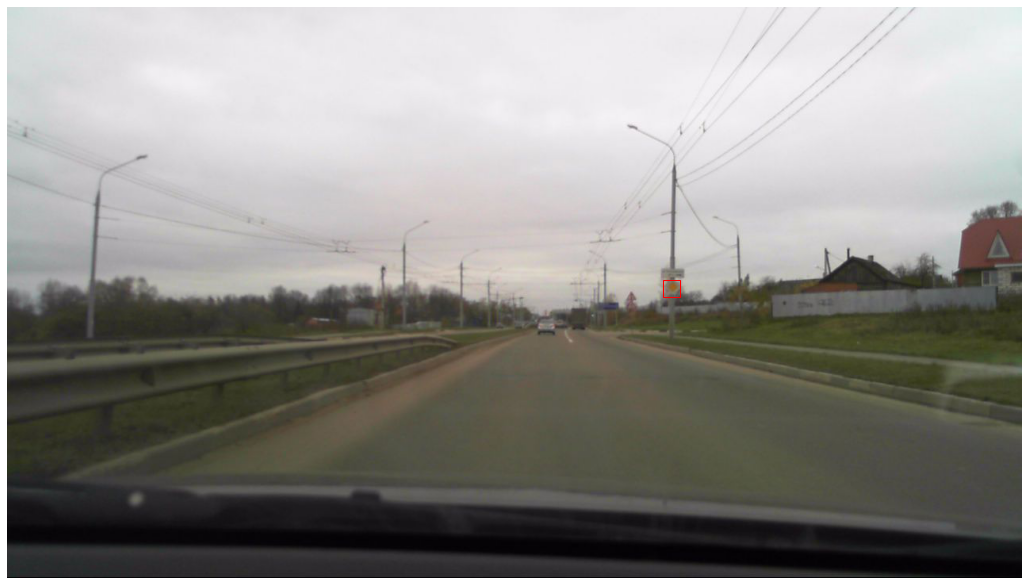

In [18]:
# посмотрим фото
df_train_anno
y = np.random.choice(df_train_anno.file_name)

im_labels = df_train_anno[df_train_anno.file_name == y].iloc[0]

im = Image.open('./' + y)
# Create figure and axes
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
# Display the image
ax.imshow(im)

# Create a Rectangle patch
rect = patches.Rectangle((im_labels.bbox[0], im_labels.bbox[1]), im_labels.bbox[2], im_labels.bbox[3], linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)
plt.axis('off')
plt.show()

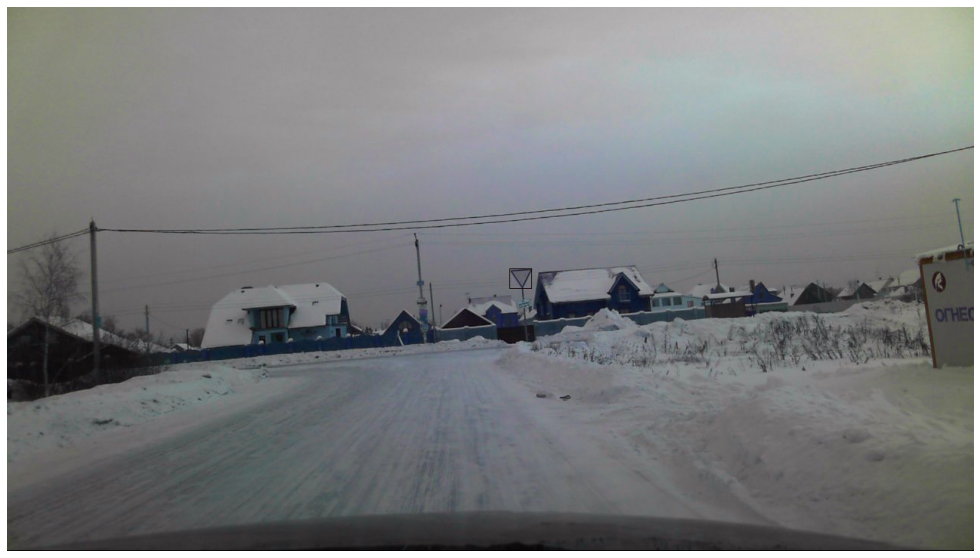

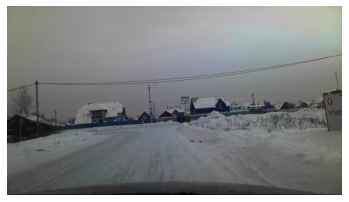

In [19]:
fig = plt.figure(figsize=(18, 10))
r3 = np.random.choice(df_train_anno.file_name)
q = cv2.imread('./' + r3, 1)
im_labels = df_train_anno[df_train_anno.file_name == r3].iloc[0]

plt.imshow(q)

rect = cv2.rectangle(q,(im_labels.bbox[0], im_labels.bbox[1]), 
                     (im_labels.bbox[0]+im_labels.bbox[2], im_labels.bbox[1]+im_labels.bbox[3]), 15)

plt.imshow(rect)
plt.axis("off")
plt.show() 

rect = cv2.rectangle(q,(im_labels.bbox[0], im_labels.bbox[1]), 
                     (im_labels.bbox[0]+im_labels.bbox[2], im_labels.bbox[1]+im_labels.bbox[3]), 15)

plt.imshow(rect)
plt.axis("off")
plt.show() 

<Figure size 720x576 with 0 Axes>

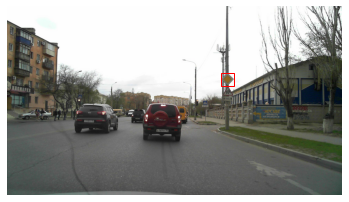

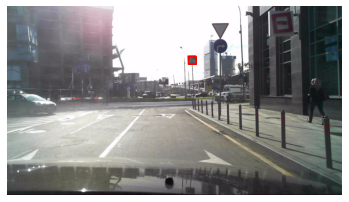

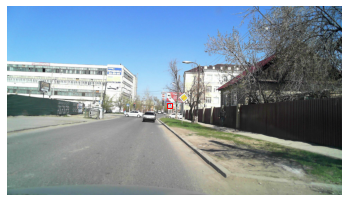

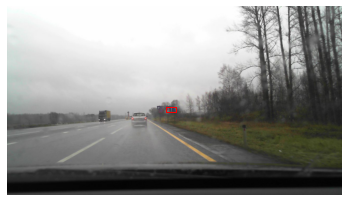

In [20]:
figure = plt.figure(figsize=(10, 8))
for i in range(1, 5):
    r = np.random.choice(df_train_anno.file_name)
    im_labels = df_train_anno[df_train_anno.file_name == r].iloc[0]
    im = Image.open('./' + r)
    fig, ax = plt.subplots()
    ax.imshow(im)
    rect = patches.Rectangle((im_labels.bbox[0], im_labels.bbox[1]), im_labels.bbox[2], im_labels.bbox[3], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.axis('off')
plt.show()

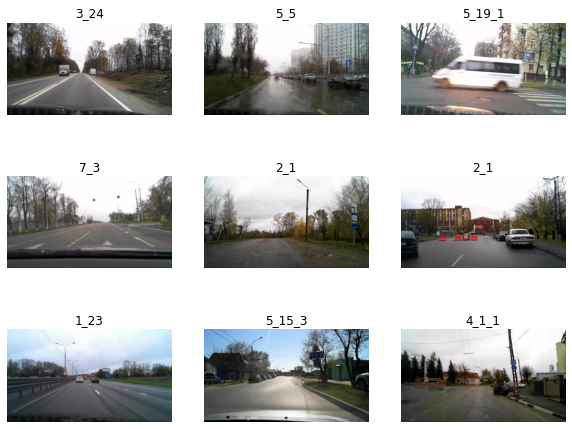

In [21]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    r = np.random.choice(df_train_anno.file_name)
    im_labels = df_train_anno[df_train_anno.file_name == r].iloc[0]
    label = df_train_anno[df_train_anno.file_name == r].iloc[0]['name']
    im = Image.open('./' + r)
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(im)
    rect = patches.Rectangle((im_labels.bbox[0], im_labels.bbox[1]), im_labels.bbox[2], im_labels.bbox[3], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
plt.show()

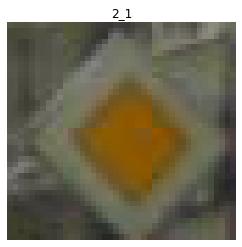

In [22]:
# посмотрим знаки
y = np.random.choice(df_train_anno.file_name)
im_labels = df_train_anno[df_train_anno.file_name == y].iloc[0]
im = Image.open('./' + y)
label = df_train_anno[df_train_anno.file_name == y].iloc[0]['name']
coordinates = [im_labels.bbox[0], im_labels.bbox[1], im_labels.bbox[0]+im_labels.bbox[2], im_labels.bbox[1]+im_labels.bbox[3]]
# cropped = im.crop([im_labels.bbox[0], im_labels.bbox[1], im_labels.bbox[0]+im_labels.bbox[2], im_labels.bbox[1]+im_labels.bbox[3]])
cropped = im.crop(coordinates)
plt.imshow(cropped)
plt.title(label)
plt.axis('off')
plt.show()

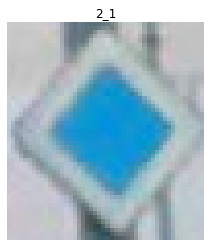

In [23]:
r3 = np.random.choice(df_train_anno.file_name)

im_labels = df_train_anno[df_train_anno.file_name == r3].iloc[0]
label = df_train_anno[df_train_anno.file_name == r3].iloc[0]['name']

q = cv2.imread('./' + r3, 1)

cropped = q[im_labels.bbox[1]:im_labels.bbox[1]+im_labels.bbox[3], im_labels.bbox[0]:im_labels.bbox[0]+im_labels.bbox[2]]

plt.imshow(cropped)
plt.title(label)
plt.axis('off')
plt.show()


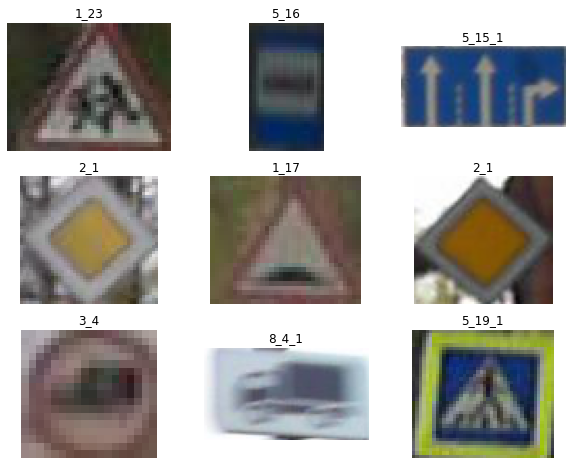

In [24]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    r = np.random.choice(df_train_anno.file_name)
    im_labels = df_train_anno[df_train_anno.file_name == r].iloc[0]
    label = df_train_anno[df_train_anno.file_name == r].iloc[0]['name']
    im = Image.open('./' + r)
    figure.add_subplot(rows, cols, i)
    coordinates = ((im_labels.bbox[0], im_labels.bbox[1], im_labels.bbox[0]+im_labels.bbox[2], im_labels.bbox[1]+im_labels.bbox[3]))
    cropped = im.crop(coordinates)
    plt.imshow(cropped)
    plt.title(label)
    plt.axis("off")
plt.show()

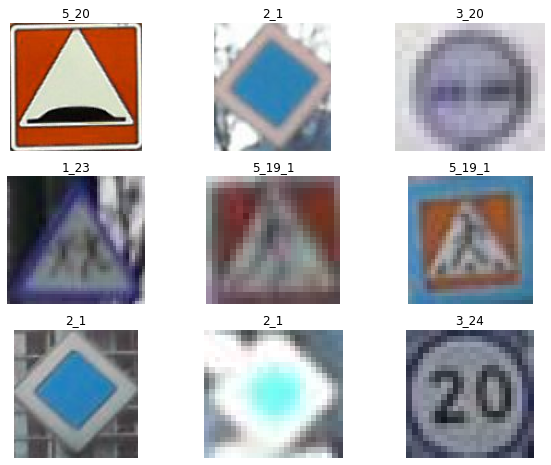

In [25]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    r3 = np.random.choice(df_train_anno.file_name)
    im_labels = df_train_anno[df_train_anno.file_name == r3].iloc[0]
    label = df_train_anno[df_train_anno.file_name == r3].iloc[0]['name']
    q = cv2.imread('./' + r3, 1)
    figure.add_subplot(rows, cols, i)
    cropped = q[im_labels.bbox[1]:im_labels.bbox[1]+im_labels.bbox[3], im_labels.bbox[0]:im_labels.bbox[0]+im_labels.bbox[2]]
    plt.imshow(cropped)
    plt.title(label)
    plt.axis('off')
plt.show()

loading annotations into memory...
Done (t=0.81s)
creating index...
index created!


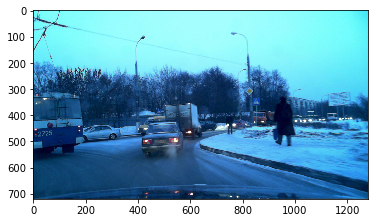

In [26]:
coco = COCO('./train_anno.json')
img_dir1 = '.'
img_dir = './rtsd-frames'
image_id = 74
img = coco.imgs[image_id]
image = np.array(Image.open(os.path.join(img_dir1, img['file_name'])))
plt.imshow(image, interpolation='nearest')
plt.show()

In [28]:
data = fo.Dataset.from_dir(
        dataset_type=fo.types.COCODetectionDataset,
        data_path='./',
        labels_path='train_anno_reduced.json',
        max_samples=10,
        shuffle=True,
        seed=51,
    )
session = fo.launch_app(data)

 100% |███████████████████| 10/10 [62.9ms elapsed, 0s remaining, 158.9 samples/s]     


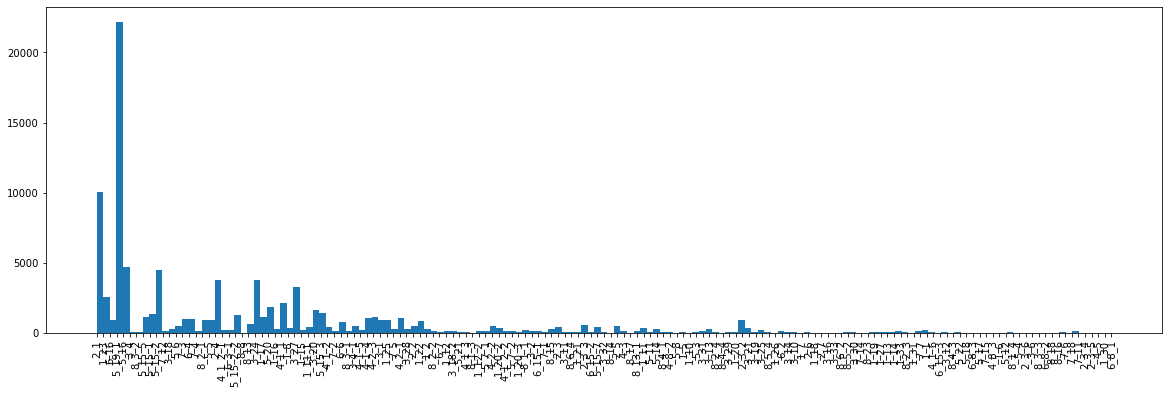

In [29]:
# посмотрим распределение дорожных знаков в датасете train
figure = plt.figure(figsize=(20, 6))
plt.hist(df_train_anno['name'], bins=155)
plt.xticks(rotation=90)
plt.show()

In [30]:
ttt = pd.DataFrame(df_train_anno['name'].value_counts()).reset_index()
ttt.columns = ['category_id', 'name']
ttt

category_id   name
0        5_19_1  22147
1           2_1  10027
2          5_16   4727
3        5_15_2   4504
4          3_24   3761
..          ...    ...
150        8_23      3
151       8_3_3      2
152         4_5      2
153        3_33      1
154       2_3_5      1

[155 rows x 2 columns]

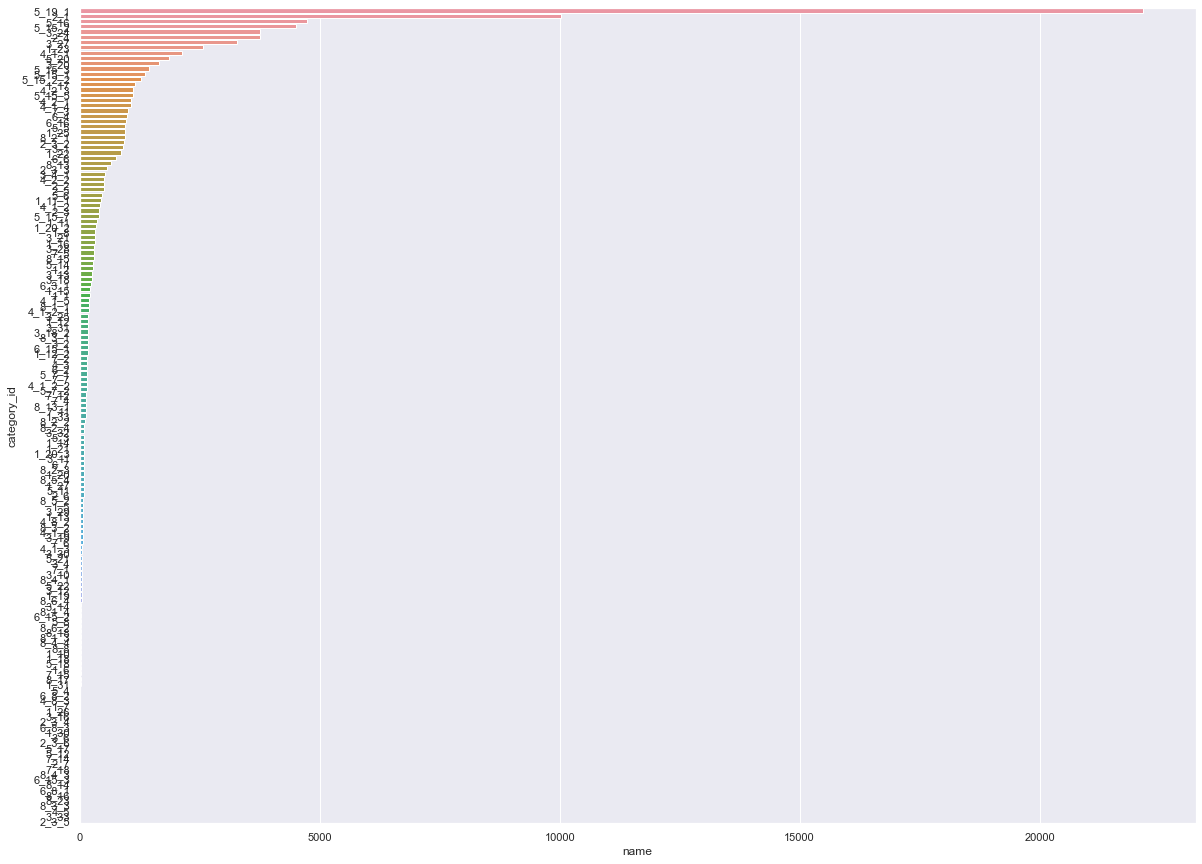

In [31]:
sns.set(rc={'figure.figsize':(20,15)})
sns.barplot(data=ttt, x='name', y="category_id")
plt.show()

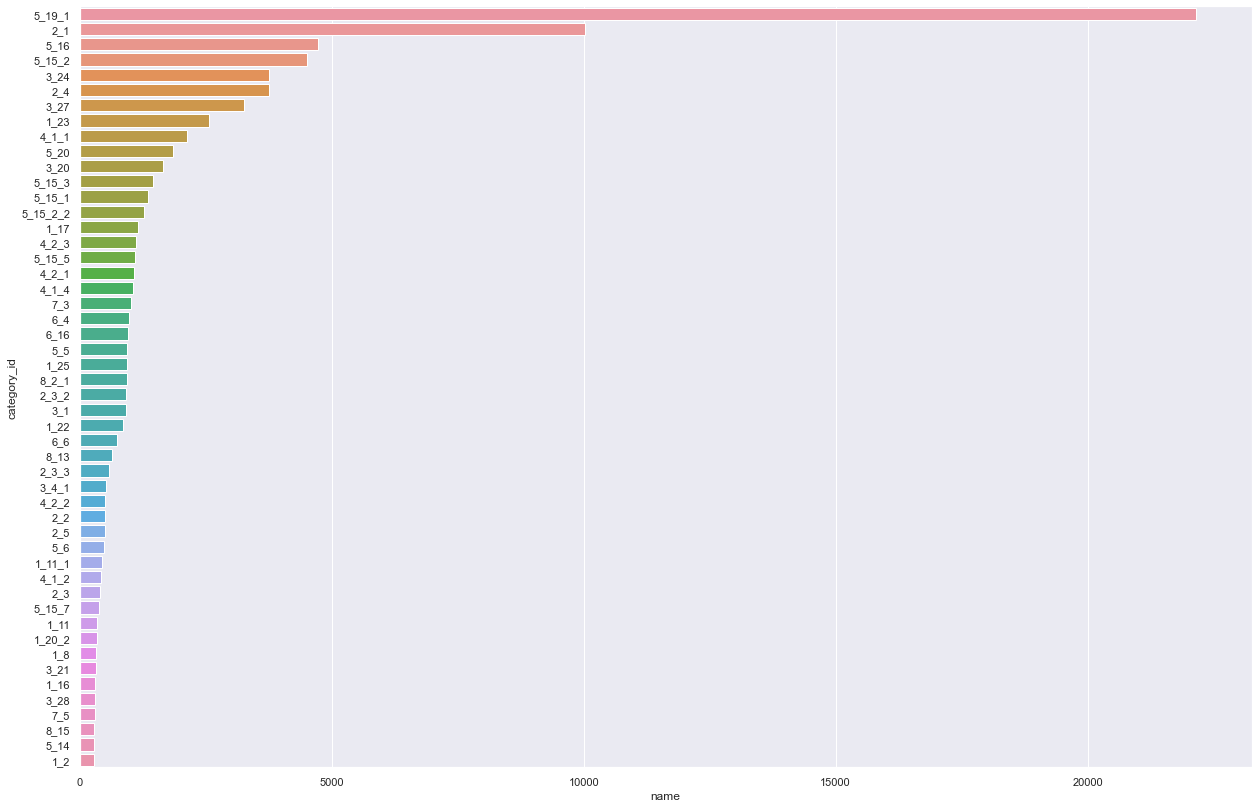

In [32]:
sns.set(rc={'figure.figsize':(21,14)})
sns.barplot(data=ttt[:50], x='name', y="category_id")
plt.show()

In [33]:
# посмотрим распределение дорожных знаков в датасете val
df_val_anno = dataset('.', 'val_anno.json')
df_val_anno.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8866 entries, 0 to 8436
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           8866 non-null   int64 
 1   image_id     8866 non-null   int64 
 2   category_id  8866 non-null   int64 
 3   area         8866 non-null   int64 
 4   bbox         8866 non-null   object
 5   iscrowd      8866 non-null   int64 
 6   name         8866 non-null   object
 7   width        8866 non-null   int64 
 8   height       8866 non-null   int64 
 9   file_name    8866 non-null   object
dtypes: int64(7), object(3)
memory usage: 761.9+ KB


In [34]:
df_val_anno['name'].value_counts()

5_19_1    2117
2_1        934
5_16       445
5_15_2     440
3_24       343
          ... 
1_26         1
7_18         1
2_7          1
5_12         1
6_8_1        1
Name: name, Length: 139, dtype: int64

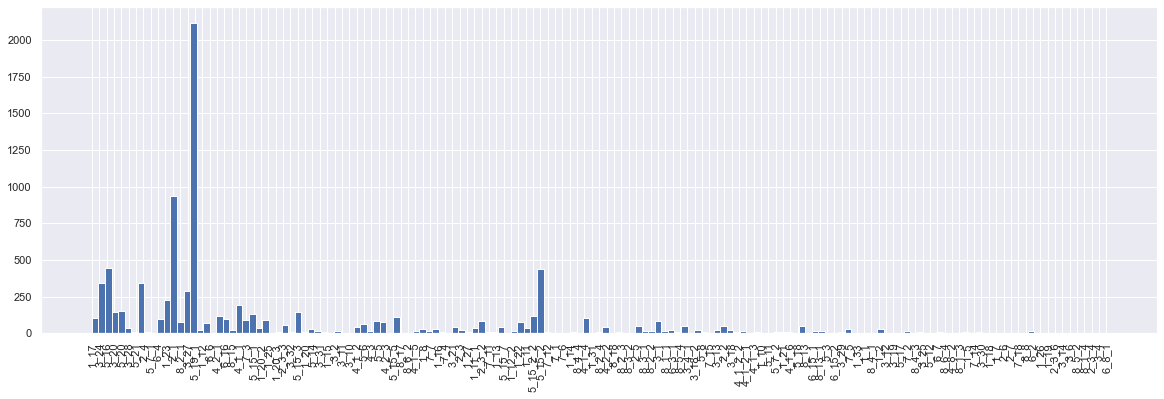

In [35]:
figure = plt.figure(figsize=(20, 6))
plt.hist(df_val_anno['name'], bins=155)
plt.xticks(rotation=90)
plt.show()

In [36]:
# посмотрим распределение дорожных знаков в датасете train_reduced
df_train_anno_reduced = dataset('.', 'train_anno_reduced.json')
df_train_anno_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 0 to 2324
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           2325 non-null   int64 
 1   image_id     2325 non-null   int64 
 2   category_id  2325 non-null   int64 
 3   area         2325 non-null   int64 
 4   bbox         2325 non-null   object
 5   iscrowd      2325 non-null   int64 
 6   name         2325 non-null   object
 7   width        2325 non-null   int64 
 8   height       2325 non-null   int64 
 9   file_name    2325 non-null   object
dtypes: int64(7), object(3)
memory usage: 199.8+ KB


In [37]:
df_train_anno_reduced['name'].value_counts()

2_1       15
3_10      15
4_1_4     15
8_5_4     15
4_1_5     15
          ..
1_16      15
1_11_1    15
6_6       15
8_5_2     15
8_23      15
Name: name, Length: 155, dtype: int64

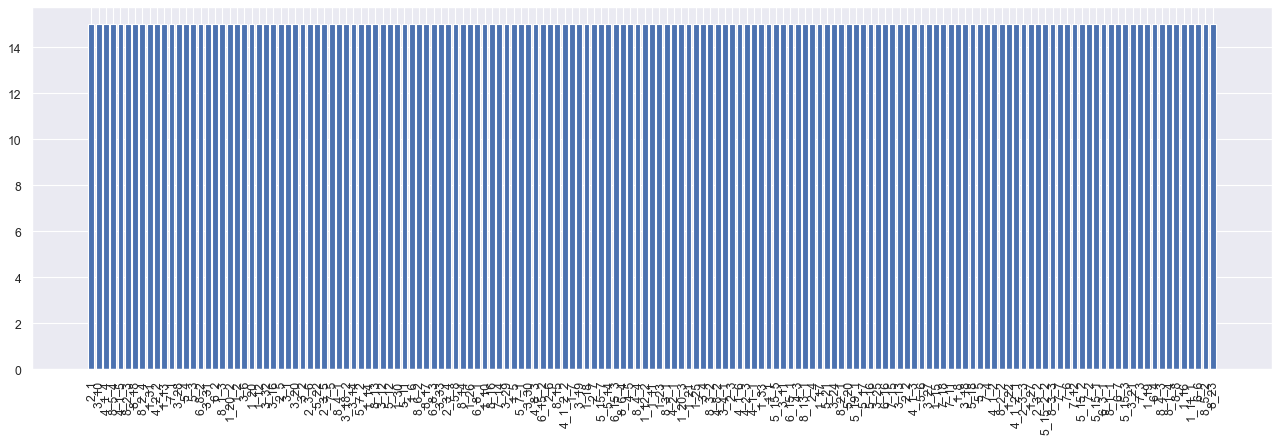

In [38]:
tt = pd.DataFrame(df_train_anno_reduced['name'].value_counts())
figure = plt.figure(figsize=(20, 6), dpi=80)
plt.bar(tt.index, tt.name)
plt.xticks(rotation=90)
plt.show()

<Figure size 1440x432 with 0 Axes>

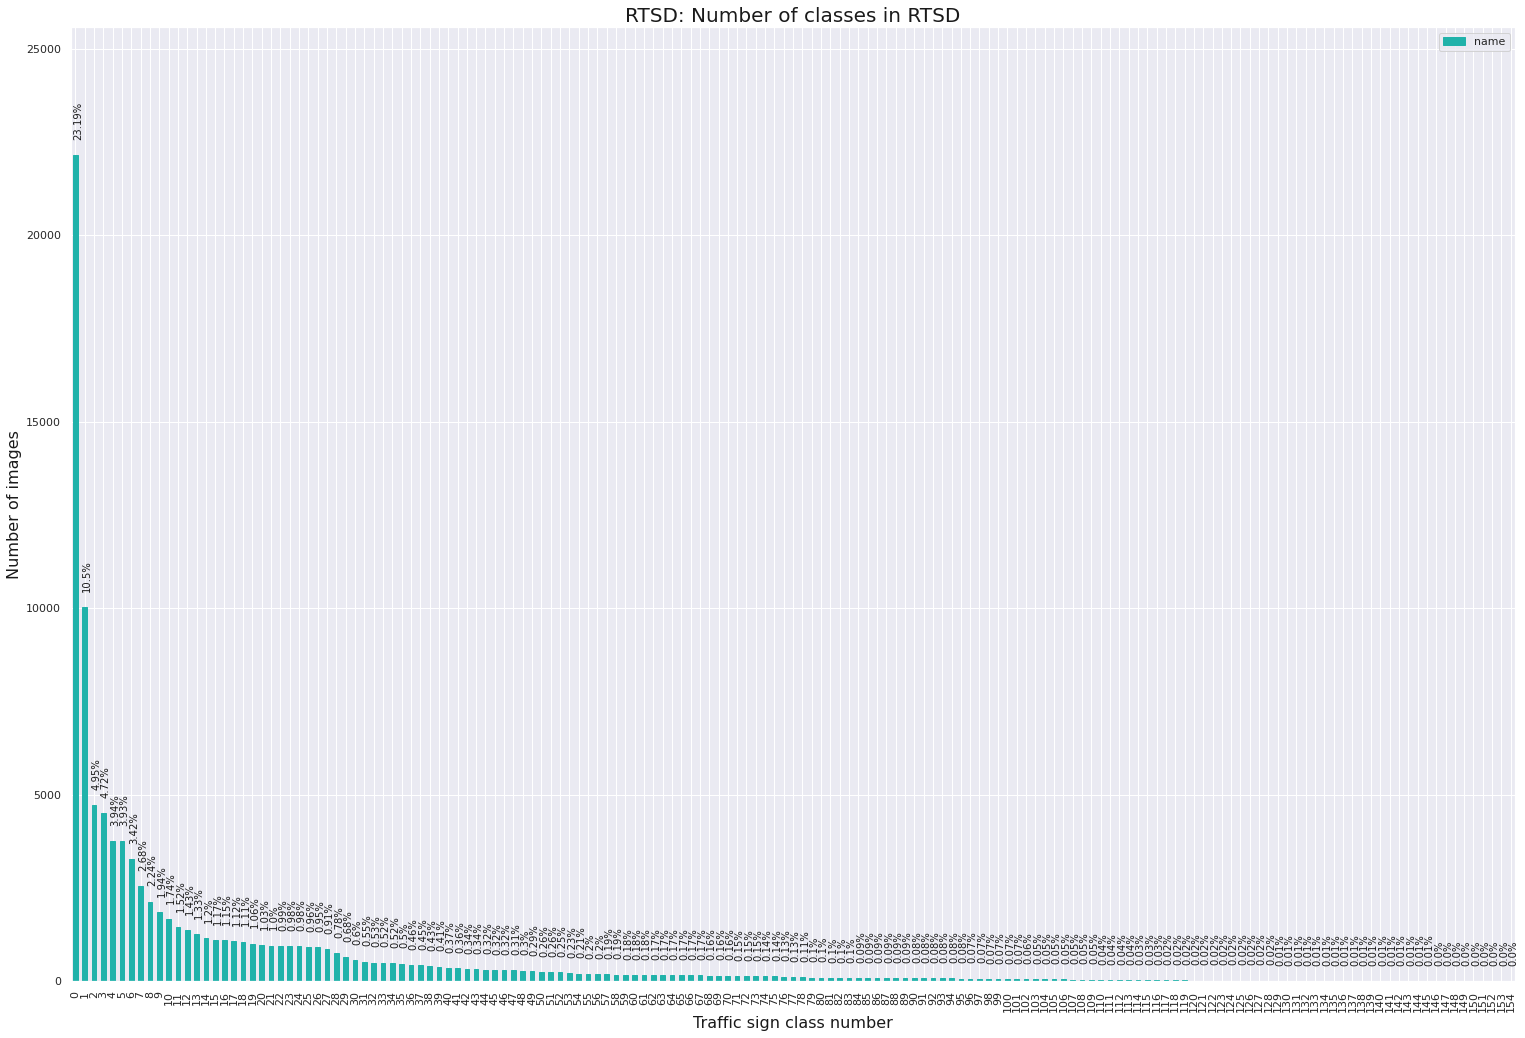

In [39]:
t = pd.DataFrame(df_train_anno['name'].value_counts()).reset_index()
t = t.drop(['index'],axis=1)

fig = plt.figure(figsize=(20, 6))

bars = t.plot.bar(color='lightseagreen', edgecolor='lightseagreen')

plt.tight_layout()
plt.style.use(['classic'])
fig.set_facecolor('w')

totals = []
for bar in bars.patches:
        totals.append(bar.get_height())
total = sum(totals)

ymin, ymax = bars.get_ylim()
bars.set_ylim(top=ymax*1.1)

for bar in bars.patches:
        bar_height = bar.get_height()
        plt.text(bar.get_x(), bar_height + ymax*0.02,
                str(round((bar_height/total)*100, 2)) + "%",
                fontsize=10, rotation=90)

plt.title('RTSD: Number of classes in RTSD', color='k', fontsize=20)
plt.xlabel('Traffic sign class number', color='k', fontsize=16)
plt.ylabel('Number of images', color='k', fontsize=16)
plt.show()

In [40]:
t

name
0    22147
1    10027
2     4727
3     4504
4     3761
..     ...
150      3
151      2
152      2
153      1
154      1

[155 rows x 1 columns]

In [41]:
# посмотрим наименование/обозначения дорожных знаков
with open(os.path.join('.', 'label_map.json'), 'r') as f:
    label_map = json.load(f)
df_label_map = pd.DataFrame.from_dict(label_map, orient='index').reset_index()
df_label_map.columns = ['name', 'category_id']
df_label_map

name  category_id
0      2_1            1
1     1_23            2
2     1_17            3
3     3_24            4
4    8_2_1            5
..     ...          ...
150   1_10          151
151   8_16          152
152   7_18          153
153   7_14          154
154   8_23          155

[155 rows x 2 columns]

In [42]:
df5 = pd.DataFrame.from_dict(label_map, orient='index').reset_index()
df5.columns = ['name', 'category_id']
df5

name  category_id
0      2_1            1
1     1_23            2
2     1_17            3
3     3_24            4
4    8_2_1            5
..     ...          ...
150   1_10          151
151   8_16          152
152   7_18          153
153   7_14          154
154   8_23          155

[155 rows x 2 columns]

In [43]:
# Приведем все знаки к одному классу
df_train_anno_1 = df_train_anno.copy()
df_train_anno_1['category_id'] = 1

df_val_anno_1 = df_val_anno.copy()
df_val_anno_1['category_id'] = 1

df_train_anno_reduced_1 = df_train_anno_reduced.copy()
df_train_anno_reduced_1['category_id'] = 1

In [44]:
# разделим df_train_anno на train / test
df_test = df_train_anno.sample(frac = 0.2)
df_train = df_train_anno.drop(df_test.index)
 
print("\n20% of the given DataFrame:")
print(df_test)
 
print("\nrest 80% of the given DataFrame:")
print(df_train)


20% of the given DataFrame:
          id  image_id  category_id  area                 bbox  iscrowd  \
88652  96863     54218           35  2124  [1163, 237, 36, 59]        0   
27339  29838     18329           35   576   [823, 324, 24, 24]        0   
28509  31133     18928            8  1551  [1246, 302, 33, 47]        0   
5656    6129      3729           43   896     [363, 0, 32, 28]        0   
35857  39175     23883            7  1722   [200, 281, 42, 41]        0   
...      ...       ...          ...   ...                  ...      ...   
29388  32089     19680           82   930   [679, 284, 30, 31]        0   
72762  79400     43134           32  1444   [782, 287, 38, 38]        0   
4605    4993      3237           22   528   [525, 239, 24, 22]        0   
44098  48219     27843            7   462  [1088, 439, 21, 22]        0   
1259    1382       903           62  1190   [671, 294, 35, 34]        0   

         name  width  height                                      file

In [45]:
def anno_1_class(anno_file):
    with open(os.path.join('.', anno_file), 'r') as read_file:
        anno_json = json.load(read_file)
    
    for i in range(len(anno_json['annotations'])):
        anno_json['annotations'][i]['category_id'] = 1    
    
    anno_json['categories'] = [{'id': 1, 'name': 'rtsd'}]
    
    anno_file_new = anno_file.split('.')[0] + '_1.json'
    
    with open(os.path.join('.', anno_file_new), 'w') as f:
        json.dump(anno_json, f)
    
    return anno_json

# train_anno_1 = anno_1_class('train_anno.json')
# val_anno_1 = anno_1_class('val_anno.json')
# train_anno_reduced_1 = anno_1_class('train_anno_reduced.json')

In [46]:
def anno_train_test_split(anno_file):
    
    with open(os.path.join('.', anno_file), 'r') as file1:
        anno_json1 = json.load(file1)
    
    x1 = int(len(anno_json1['images'])*0.2)
    file_train = anno_file.split('.')[0] + '_train.json'
          
    del anno_json1['images'][:x1]
    
    with open(os.path.join('.', file_train), 'w') as f1:
                        json.dump(anno_json1, f1)
    
    
    with open(os.path.join('.', anno_file), 'r') as file2:
            anno_json2 = json.load(file2)
    
    
    x2 = int(len(anno_json2['images'])*0.2)
    y2 = int(len(anno_json2['images']))
    
    file_test= anno_file.split('.')[0] + '_test.json'
    
    del anno_json2['images'][x2:y2]
            
    with open(os.path.join('.', file_test), 'w') as f2:
                        json.dump(anno_json2, f2)  
            

    return anno_json1, anno_json2

In [47]:
train1, test1 = anno_train_test_split('train_anno_1.json')

In [48]:
with open(os.path.join('.', 'train_anno_1_test.json'), 'r') as file1:
        anno_json1 = json.load(file1)
        
with open(os.path.join('.', 'train_anno_1_train.json'), 'r') as file2:
        anno_json2 = json.load(file2)
        
with open(os.path.join('.', 'train_anno_1.json'), 'r') as file3:
        anno_json3 = json.load(file3)
        
len(anno_json1['images']), len(anno_json2['images']), len(anno_json3['images']),(len(anno_json1['images'])+len(anno_json2['images']))

(10837, 43351, 54188, 54188)

In [49]:
# создание нового класса "не знак"
dfa = df_train_anno.copy().reset_index()
dfa = dfa.drop(['index'],axis=1)
dfa.iloc[10:50, 4] = dfa.iloc[10:50, 4].apply(lambda x: [int(x[0]-0.5*x[2]), int(x[1]-0.5*x[3]), x[2], x[3]])
dfa.iloc[10:50, 2] = 156

In [50]:
dfa1 = dfa.iloc[10:50].reset_index()
dfa1.drop(['index'],axis=1).head()

id  image_id  category_id  area                bbox  iscrowd    name  \
0   86        50          156  5170  [878, 73, 110, 47]        0    6_16   
1  125        71          156   504  [254, 346, 21, 24]        0     2_1   
2  126        71          156   462  [267, 379, 21, 22]        0  5_19_1   
3  127        72          156   483  [451, 330, 21, 23]        0     2_1   
4  128        72          156   420  [464, 364, 20, 21]        0  5_19_1   

   width  height                                    file_name  
0   1280     720  rtsd-frames/autosave01_02_2012_09_16_35.jpg  
1   1280     720  rtsd-frames/autosave01_02_2012_09_17_21.jpg  
2   1280     720  rtsd-frames/autosave01_02_2012_09_17_21.jpg  
3   1280     720  rtsd-frames/autosave01_02_2012_09_17_22.jpg  
4   1280     720  rtsd-frames/autosave01_02_2012_09_17_22.jpg

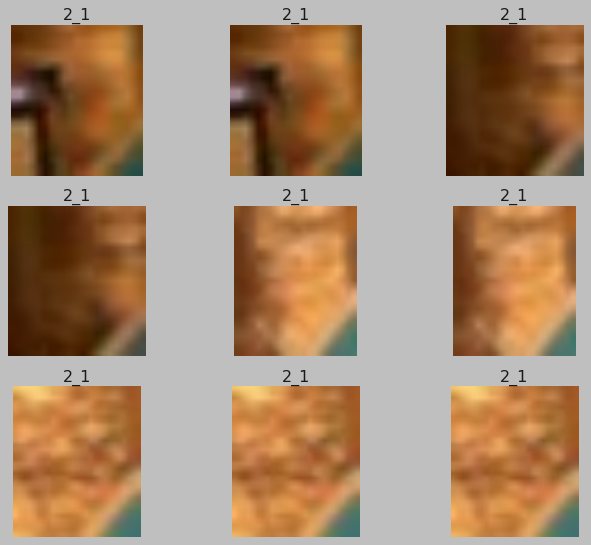

In [51]:
# создание нового класса "не знак"
figure = plt.figure(figsize=(10, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
#     r3 = np.random.choice(dfa1.file_name)
    r3 = dfa1.file_name[i]
    im_labels = dfa1[dfa1.file_name == r3].iloc[0]
    label = dfa1[dfa1.file_name == r3].iloc[0]['name']
    q = cv2.imread('./' + r3, 1)
    figure.add_subplot(rows, cols, i)
    cropped = q[im_labels.bbox[1]:im_labels.bbox[1]+im_labels.bbox[3], im_labels.bbox[0]:im_labels.bbox[0]+im_labels.bbox[2]]
    plt.imshow(cropped)
    plt.title(label)
    plt.axis('off')
plt.show()

In [52]:
# функция загрузки датасета в pd
def dataset_156(path, name_f):
  
  with open(os.path.join(path, name_f), 'r') as f:
    anno = json.load(f)

    obj1 = anno.get('images')
    df1 = pd.json_normalize(obj1)
    obj2 = anno.get('annotations')
    df2 = pd.json_normalize(obj2)
    obj3 = anno.get('categories')
    df3 = pd.json_normalize(obj3)
    t = df2.merge(df3.set_index('id'), left_on='category_id',right_index=True)
    df= t.merge(df1.set_index('id'), left_on='image_id',right_index=True)
    dfa = df.reset_index()
    dfa = dfa.drop(['index'],axis=1)
    dfa.iloc[10:50, 4] = dfa.iloc[10:50, 4].apply(lambda x: [int(x[0]-0.5*x[2]), int(x[1]-0.5*x[3]), x[2], x[3]])
    dfa.iloc[10:50, 2] = 156
  
  return dfa

In [53]:
df_a = dataset_156('.', 'train_anno.json')
df_a.head()

id  image_id  category_id  area                bbox  iscrowd  name  width  \
0   0         0            1   324  [649, 376, 18, 18]        0   2_1   1280   
1   1         1            1   420  [671, 356, 20, 21]        0   2_1   1280   
2   2         2            1   702  [711, 332, 27, 26]        0   2_1   1280   
3   3         3            1  1332  [764, 290, 37, 36]        0   2_1   1280   
4   4         3            2   289  [684, 384, 17, 17]        0  1_23   1280   

   height                                    file_name  
0     720  rtsd-frames/autosave01_02_2012_09_13_33.jpg  
1     720  rtsd-frames/autosave01_02_2012_09_13_34.jpg  
2     720  rtsd-frames/autosave01_02_2012_09_13_35.jpg  
3     720  rtsd-frames/autosave01_02_2012_09_13_36.jpg  
4     720  rtsd-frames/autosave01_02_2012_09_13_36.jpg

In [54]:
# создание маски знака

In [55]:
df_val_anno_1

id  image_id  category_id  area                 bbox  iscrowd   name  \
0     37471     22978            1   810   [622, 375, 30, 27]        0   1_17   
53    64051     34704            1   667  [1050, 436, 29, 23]        0   1_17   
54    64052     34704            1   675  [1052, 463, 27, 25]        0   3_24   
61    58803     32165            1  1720  [1033, 506, 43, 40]        0   1_17   
60    58802     32165            1  1271   [326, 485, 31, 41]        0   5_16   
...     ...       ...          ...   ...                  ...      ...    ...   
6670  94331     52560            1   378   [774, 367, 18, 21]        0   1_14   
6816  96066     53689            1   380   [891, 286, 20, 19]        0   1_14   
6894  96069     53692            1   783   [952, 278, 29, 27]        0   1_14   
8027  88718     48619            1   690   [898, 365, 30, 23]        0    1_7   
8436  70504     38147            1   966   [820, 316, 23, 42]        0  6_8_1   

      width  height                                      file_name  
0      1280     720  rtsd-frames/autosave10_10_2012_13_50_36_1.jpg  
53     1920    1080  rtsd-frames/autosave16_04_2013_15_11_26_1.jpg  
54     1920    1080  rtsd-frames/autosave16_04_2013_15_11_26_1.jpg  
61     1920    1080  rtsd-frames/autosave16_04_2013_13_19_50_2.jpg  
60     1920    1080  rtsd-frames/autosave16_04_2013_13_19_50_2.jpg  
...     ...     ...                                            ...  
6670   1280     720  rtsd-frames/autosave23_10_2012_15_12_50_0.jpg  
6816   1280     720  rtsd-frames/autosave24_10_2012_10_12_30_1.jpg  
6894   1280     720  rtsd-frames/autosave24_10_2012_10_12_31_0.jpg  
8027   1280     720  rtsd-frames/autosave23_10_2012_10_25_11_1.jpg  
8436   1280     720  rtsd-frames/autosave16_10_2012_08_36_42_0.jpg  

[8866 rows x 10 columns]

In [56]:
df_mask = df_val_anno_1.copy()
df_mask

id  image_id  category_id  area                 bbox  iscrowd   name  \
0     37471     22978            1   810   [622, 375, 30, 27]        0   1_17   
53    64051     34704            1   667  [1050, 436, 29, 23]        0   1_17   
54    64052     34704            1   675  [1052, 463, 27, 25]        0   3_24   
61    58803     32165            1  1720  [1033, 506, 43, 40]        0   1_17   
60    58802     32165            1  1271   [326, 485, 31, 41]        0   5_16   
...     ...       ...          ...   ...                  ...      ...    ...   
6670  94331     52560            1   378   [774, 367, 18, 21]        0   1_14   
6816  96066     53689            1   380   [891, 286, 20, 19]        0   1_14   
6894  96069     53692            1   783   [952, 278, 29, 27]        0   1_14   
8027  88718     48619            1   690   [898, 365, 30, 23]        0    1_7   
8436  70504     38147            1   966   [820, 316, 23, 42]        0  6_8_1   

      width  height                                      file_name  
0      1280     720  rtsd-frames/autosave10_10_2012_13_50_36_1.jpg  
53     1920    1080  rtsd-frames/autosave16_04_2013_15_11_26_1.jpg  
54     1920    1080  rtsd-frames/autosave16_04_2013_15_11_26_1.jpg  
61     1920    1080  rtsd-frames/autosave16_04_2013_13_19_50_2.jpg  
60     1920    1080  rtsd-frames/autosave16_04_2013_13_19_50_2.jpg  
...     ...     ...                                            ...  
6670   1280     720  rtsd-frames/autosave23_10_2012_15_12_50_0.jpg  
6816   1280     720  rtsd-frames/autosave24_10_2012_10_12_30_1.jpg  
6894   1280     720  rtsd-frames/autosave24_10_2012_10_12_31_0.jpg  
8027   1280     720  rtsd-frames/autosave23_10_2012_10_25_11_1.jpg  
8436   1280     720  rtsd-frames/autosave16_10_2012_08_36_42_0.jpg  

[8866 rows x 10 columns]

In [57]:
# создание маски знака
df_mask = df_train_anno_reduced_1.copy()
df_mask = df_mask[['file_name', 'width', 'height', 'category_id', 'bbox', 'id', 'image_id', 'area', 'iscrowd', 'name']]
df_mask.category_id = 1
df_mask['xmin'] = df_mask.bbox.apply(lambda x: x[0])
df_mask['ymin'] = df_mask.bbox.apply(lambda x: x[1])
df_mask['xmax'] = df_mask.bbox.apply(lambda x: x[0]+x[2])
df_mask['ymax'] = df_mask.bbox.apply(lambda x: x[1]+x[3])
df_mask = df_mask[['file_name', 'width', 'height', 'category_id', 'xmin', 'ymin', 'xmax', 'ymax', 'bbox', 'id', 'image_id', 'area', 'iscrowd', 'name' ]]
df_mask

file_name  width  height  \
0     rtsd-frames/autosave10_10_2012_09_56_26_0.jpg   1280     720   
1     rtsd-frames/autosave16_04_2013_14_36_03_2.jpg   1920    1080   
2     rtsd-frames/autosave23_10_2012_10_24_19_1.jpg   1280     720   
3     rtsd-frames/autosave16_10_2012_11_40_34_3.jpg   1280     720   
4     rtsd-frames/autosave10_10_2012_08_30_37_2.jpg   1280     720   
...                                             ...    ...     ...   
2318  rtsd-frames/autosave24_10_2013_11_29_00_0.jpg   1280     720   
2319  rtsd-frames/autosave24_10_2013_11_29_00_2.jpg   1280     720   
2322  rtsd-frames/autosave24_10_2013_11_29_00_2.jpg   1280     720   
2323  rtsd-frames/autosave24_10_2013_11_29_00_2.jpg   1280     720   
2324  rtsd-frames/autosave24_10_2013_11_29_00_2.jpg   1280     720   

      category_id  xmin  ymin  xmax  ymax                  bbox      id  \
0               1   754   390   785   423    [754, 390, 31, 33]   31193   
1               1  1827   162  1919   312  [1827, 162, 92, 150]   61999   
2               1  1148   175  1244   256   [1148, 175, 96, 81]   88705   
3               1   735   168   777   210    [735, 168, 42, 42]   76908   
4               1   808   324   839   352    [808, 324, 31, 28]   27687   
...           ...   ...   ...   ...   ...                   ...     ...   
2318            1   762   367   798   384    [762, 367, 36, 17]  102416   
2319            1  1203   283  1279   331   [1203, 283, 76, 48]  102422   
2322            1  1203   283  1279   331   [1203, 283, 76, 48]  102422   
2323            1  1203   283  1279   331   [1203, 283, 76, 48]  102422   
2324            1  1203   283  1279   331   [1203, 283, 76, 48]  102422   

      image_id   area  iscrowd  name  
0        18983   1023        0   2_1  
1        33712  13800        0   2_1  
2        48608   7776        0   2_1  
3        41763   1764        0   2_1  
4        16927    868        0   2_1  
...        ...    ...      ...   ...  
2318     57822    612        0  8_23  
2319     57824   3648        0  8_23  
2322     57824   3648        0  8_23  
2323     57824   3648        0  8_23  
2324     57824   3648        0  8_23  

[2325 rows x 14 columns]

In [58]:
# функция загрузки датасета в pd
def dataset_1_mask(path, name_f):
  
  with open(os.path.join(path, name_f), 'r') as f:
    anno = json.load(f)

    obj1 = anno.get('images')
    df1 = pd.json_normalize(obj1)
    obj2 = anno.get('annotations')
    df2 = pd.json_normalize(obj2)
    obj3 = anno.get('categories')
    df3 = pd.json_normalize(obj3)
    t = df2.merge(df3.set_index('id'), left_on='category_id',right_index=True)
    df= t.merge(df1.set_index('id'), left_on='image_id',right_index=True)
    df_mask = df[['file_name', 'width', 'height', 'category_id', 'bbox', 'id', 'image_id', 'area', 'iscrowd', 'name']]
    df_mask.category_id = 1
    df_mask['xmin'] = df_mask.bbox.apply(lambda x: x[0])
    df_mask['ymin'] = df_mask.bbox.apply(lambda x: x[1])
    df_mask['xmax'] = df_mask.bbox.apply(lambda x: x[0]+x[2])
    df_mask['ymax'] = df_mask.bbox.apply(lambda x: x[1]+x[3])
    df_mask = df_mask[['file_name', 'width', 'height', 'category_id', 'xmin', 'ymin', 'xmax', 'ymax', 'bbox', 'id', 'image_id', 'area', 'iscrowd', 'name' ]]
    
  
  return df_mask

In [59]:
train = dataset_1_mask('.', 'train_anno.json')
train.head()

file_name  width  height  category_id  \
0  rtsd-frames/autosave01_02_2012_09_13_33.jpg   1280     720            1   
1  rtsd-frames/autosave01_02_2012_09_13_34.jpg   1280     720            1   
2  rtsd-frames/autosave01_02_2012_09_13_35.jpg   1280     720            1   
3  rtsd-frames/autosave01_02_2012_09_13_36.jpg   1280     720            1   
4  rtsd-frames/autosave01_02_2012_09_13_36.jpg   1280     720            1   

   xmin  ymin  xmax  ymax                bbox  id  image_id  area  iscrowd  \
0   649   376   667   394  [649, 376, 18, 18]   0         0   324        0   
1   671   356   691   377  [671, 356, 20, 21]   1         1   420        0   
2   711   332   738   358  [711, 332, 27, 26]   2         2   702        0   
3   764   290   801   326  [764, 290, 37, 36]   3         3  1332        0   
4   684   384   701   401  [684, 384, 17, 17]   4         3   289        0   

   name  
0   2_1  
1   2_1  
2   2_1  
3   2_1  
4  1_23

In [60]:
# функция загрузки датасета в pd
def dataset_2_mask(path, name_f):
  
  with open(os.path.join(path, name_f), 'r') as f:
    anno = json.load(f)

    obj1 = anno.get('images')
    df1 = pd.json_normalize(obj1)
    obj2 = anno.get('annotations')
    df2 = pd.json_normalize(obj2)
    obj3 = anno.get('categories')
    df3 = pd.json_normalize(obj3)
    t = df2.merge(df3.set_index('id'), left_on='category_id',right_index=True)
    df= t.merge(df1.set_index('id'), left_on='image_id',right_index=True)
    df_mask = df[['file_name', 'width', 'height', 'category_id', 'bbox', 'id', 'image_id', 'area', 'iscrowd', 'name']]
    df_mask.category_id = 1
    df_mask['x'] = df_mask.bbox.apply(lambda x: x[0])
    df_mask['y'] = df_mask.bbox.apply(lambda x: x[1])
    df_mask['w'] = df_mask.bbox.apply(lambda x: x[2])
    df_mask['h'] = df_mask.bbox.apply(lambda x: x[3])
    df_mask = df_mask[['file_name', 'width', 'height', 'category_id', 'x', 'y', 'w', 'h', 'bbox', 'id', 'image_id', 'area', 'iscrowd', 'name' ]]
    
  
  return df_mask

In [61]:
train1 = dataset_2_mask('.', 'train_anno.json')
train1.head()

file_name  width  height  category_id  \
0  rtsd-frames/autosave01_02_2012_09_13_33.jpg   1280     720            1   
1  rtsd-frames/autosave01_02_2012_09_13_34.jpg   1280     720            1   
2  rtsd-frames/autosave01_02_2012_09_13_35.jpg   1280     720            1   
3  rtsd-frames/autosave01_02_2012_09_13_36.jpg   1280     720            1   
4  rtsd-frames/autosave01_02_2012_09_13_36.jpg   1280     720            1   

     x    y   w   h                bbox  id  image_id  area  iscrowd  name  
0  649  376  18  18  [649, 376, 18, 18]   0         0   324        0   2_1  
1  671  356  20  21  [671, 356, 20, 21]   1         1   420        0   2_1  
2  711  332  27  26  [711, 332, 27, 26]   2         2   702        0   2_1  
3  764  290  37  36  [764, 290, 37, 36]   3         3  1332        0   2_1  
4  684  384  17  17  [684, 384, 17, 17]   4         3   289        0  1_23

In [62]:
# создание маски знака
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

def create_bb_array(x):
    """Генерируем массив bounding box'a из столбца train_df"""
    return np.array([x[5],x[4],x[7],x[6]])


def create_mask(bb, x):
    """Создаем маску для bounding box'a такого же шейпа как и изображение"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y


def mask_to_bb(Y):
    """Конвертируем маску Y в bounding box'a, принимая 0 как фоновый ненулевой объект """
    cols, rows = np.nonzero(Y)
    if len(cols) == 0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)



def resize_image_bb(read_path, write_path, bb, sz):
    """Ресайзим изображение и его bounding box и записываем изображение в новый путь"""
    im = read_image(read_path)
    im_resized = cv2.resize(im, (sz, sz))
    Y_resized = cv2.resize(create_mask(bb, im), (sz, sz))
    new_path = write_path+read_path
#     cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

In [63]:
IM_SIZE = 1280
new_paths = []
new_bbs = []
train_path_resized = './images_resized/'
# Path.mkdir(train_path_resized, exist_ok=True)

for index, row in df_mask.iterrows():
    new_path,new_bb = resize_image_bb(row['file_name'], train_path_resized, create_bb_array(row.values), IM_SIZE)
    new_paths.append(new_path)
    new_bbs.append(new_bb)
     
df_mask['new_path'] = new_paths
df_mask['new_bb'] = new_bbs

df_mask.head()

file_name  width  height  category_id  \
0  rtsd-frames/autosave10_10_2012_09_56_26_0.jpg   1280     720            1   
1  rtsd-frames/autosave16_04_2013_14_36_03_2.jpg   1920    1080            1   
2  rtsd-frames/autosave23_10_2012_10_24_19_1.jpg   1280     720            1   
3  rtsd-frames/autosave16_10_2012_11_40_34_3.jpg   1280     720            1   
4  rtsd-frames/autosave10_10_2012_08_30_37_2.jpg   1280     720            1   

   xmin  ymin  xmax  ymax                  bbox     id  image_id   area  \
0   754   390   785   423    [754, 390, 31, 33]  31193     18983   1023   
1  1827   162  1919   312  [1827, 162, 92, 150]  61999     33712  13800   
2  1148   175  1244   256   [1148, 175, 96, 81]  88705     48608   7776   
3   735   168   777   210    [735, 168, 42, 42]  76908     41763   1764   
4   808   324   839   352    [808, 324, 31, 28]  27687     16927    868   

   iscrowd name                                           new_path  \
0        0  2_1  ./images_resized/rtsd-frames/autosave10_10_201...   
1        0  2_1  ./images_resized/rtsd-frames/autosave16_04_201...   
2        0  2_1  ./images_resized/rtsd-frames/autosave23_10_201...   
3        0  2_1  ./images_resized/rtsd-frames/autosave16_10_201...   
4        0  2_1  ./images_resized/rtsd-frames/autosave10_10_201...   

                           new_bb  
0    [692.0, 754.0, 752.0, 784.0]  
1  [191.0, 1218.0, 369.0, 1279.0]  
2  [310.0, 1148.0, 455.0, 1243.0]  
3    [298.0, 735.0, 373.0, 776.0]  
4    [575.0, 808.0, 626.0, 838.0]

(1080, 1920, 3)


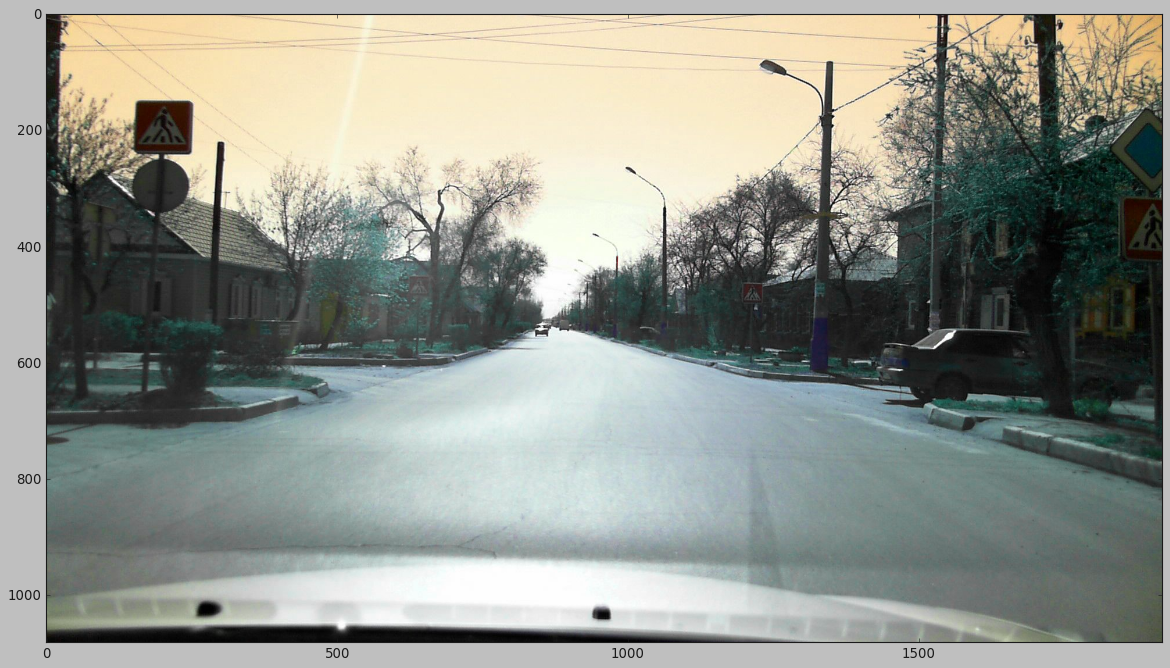

In [64]:
# создание маски знака
fig = plt.figure(figsize=(18, 10))

im = cv2.imread(str(df_mask.values[1][0]))
bb = create_bb_array(df_mask.values[1])
print(im.shape)

Y = create_mask(bb, im)
mask_to_bb(Y)

plt.imshow(im)

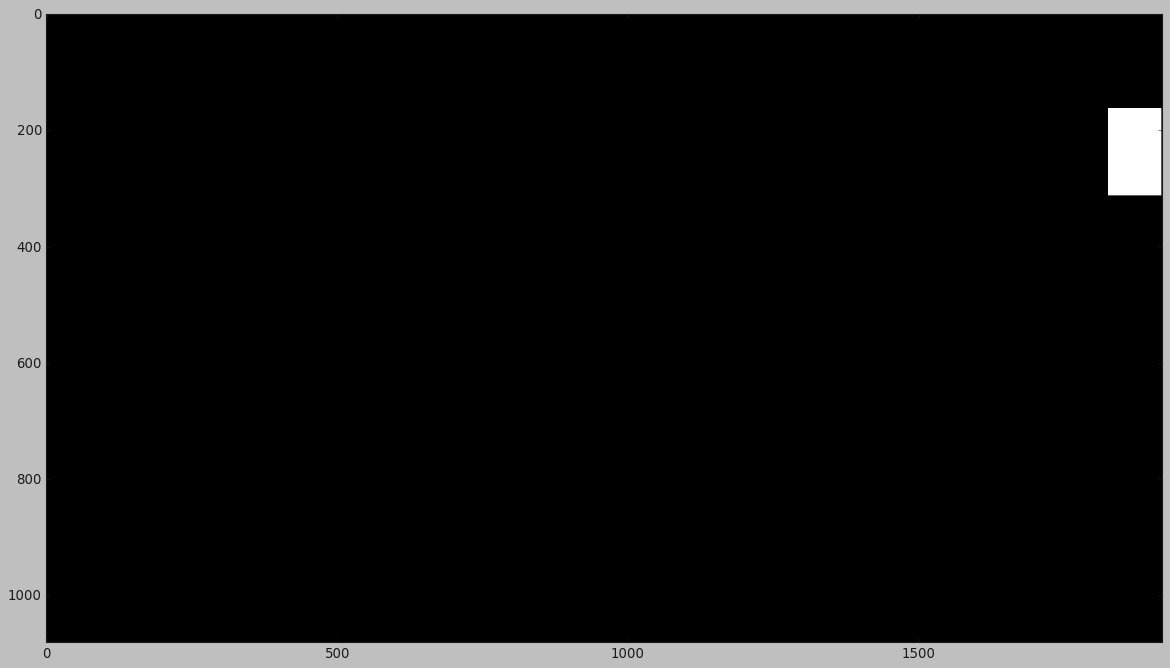

In [65]:
# создание маски знака
fig = plt.figure(figsize=(18, 10))
plt.imshow(Y, cmap='gray')

In [72]:
def create_bb_array1(x):
    """Генерируем массив bounding box'a из столбца train_df"""
    return np.array(x[4])


def create_mask1(bb, x):
    """Создаем маску для bounding box'a такого же шейпа как и изображение"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.int)
    bb[2] = bb[0]+bb[2]
    bb[3] = bb[1]+bb[3]
    Y[bb[1]:bb[3], bb[0]:bb[2]] = 1.
    return Y


def mask_to_bb1(Y):
    """Конвертируем маску Y в bounding box'a, принимая 0 как фоновый ненулевой объект """
    cols, rows = np.nonzero(Y)
    if len(cols) == 0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)



(1080, 1920, 3)


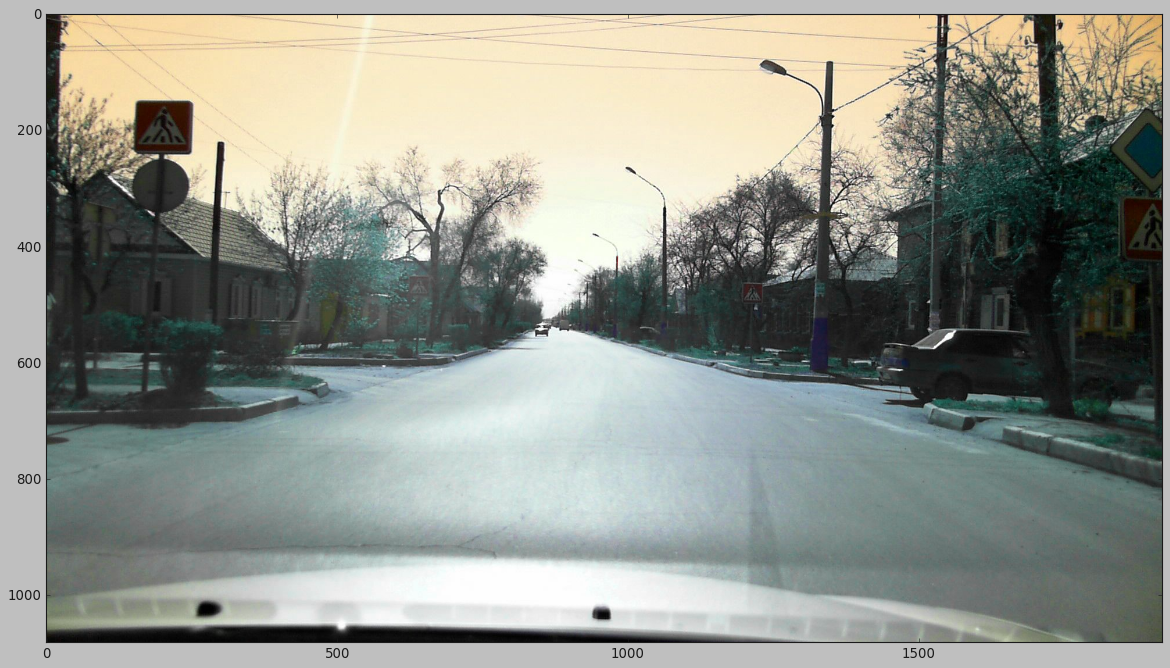

In [73]:
# создание маски знака
fig = plt.figure(figsize=(18, 10))

im1 = cv2.imread(str(df_train_anno_reduced_1.values[50][9]))
bb1 = create_bb_array1(df_train_anno_reduced_1.values[50])
print(im1.shape)

Y1 = create_mask1(bb1, im1)
mask_to_bb1(Y1)

plt.imshow(im)

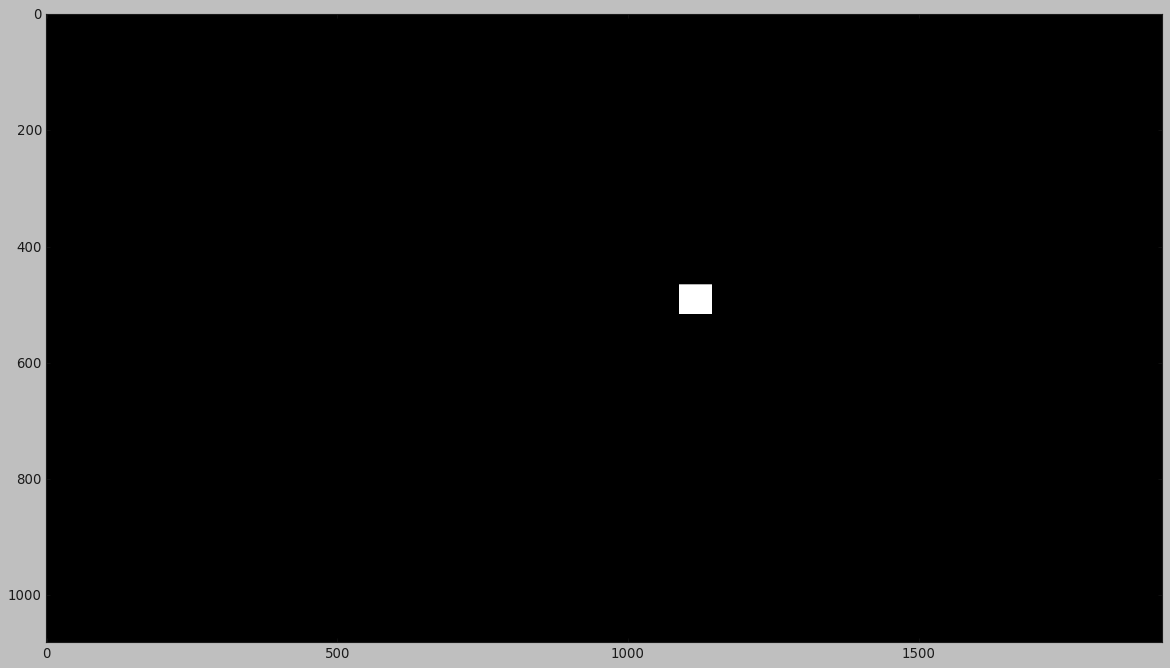

In [74]:
# создание маски знака
fig = plt.figure(figsize=(18, 10))
plt.imshow(Y1, cmap='gray')

# Названия знаков

https://www.drom.ru/pdd/pdd/signs/

name     название знака                   category_id

0_0 : не знак : 156

1_1 : Железнодорожный переезд со шлагбаумом : 119
    
1_2 : Железнодорожный переезд без шлагбаума : 80
    
1_5 : Пересечение с трамвайной линией : 130
    
1_6 : Пересечение равнозначных дорог : 137
    
1_7 : Пересечение с круговым движением  : 111
    
1_8 : Светофорное регулирование : 56
    
1_10 : Выезд на набережную : 151
    
1_11 : Опасный поворот (направо) : 62
    
1_11_1 : Опасный поворот (налево) : 39
    
1_12 : Опасные повороты (первый направо) : 66
    
1_12_2 : Опасные повороты (первый налево) : 64
    
1_13 : Крутой спуск : 103
    
1_14 : Крутой подъём : 104
    
1_15 : Скользкая дорога : 27
    
1_16 : Неровная дорога : 38
    
1_17 : Искусственная неровность : 3
    
1_18 : Выброс гравия : 113
    
1_19 : Опасная обочина : 34
    
1_20 : Сужение дороги (с обеих сторон) : 65
    
1_20_2:  Сужение дороги (с правой стороны) : 81
    
1_20_3 : Сужение дороги (с левой стороны) : 16
    
1_21 : Двустороннее движение : 101
    
1_22 : Пешеходный переход : 52
    
1_23 : Дети : 2
    
1_25 : Дорожные работы : 17
    
1_26 : Перегон скота : 147
    
1_27 : Дикие животные : 53
    
1_30 : Низколетящие самолёты : 135
    
1_31: Тоннель : 90
    
1_33 : Прочие опасности : 24
    
2_1 : Главная дорога : 1
    
2_2 : Конец главной дороги : 12
    
2_3 : Пересечение со второстепенной дорогой : 58
    
2_3_2 : Примыкание второстепенной дороги (справа) : 54
    
2_3_3 : Примыкание второстепенной дороги (слева) : 60
    
2_3_4 : Примыкание второстепенной дороги (справа) : 105
    
2_3_5 : Примыкание второстепенной дороги (слева) : 76
    
2_3_6 : Примыкание второстепенной дороги (справа) : 73
    
2_4 : Уступите дорогу : 13
    
2_5 : Движение без остановки запрещено : 68
    
2_6 : Преимущество встречного движения : 108
    
2_7 : Преимущество перед встречным движением : 114
    
3_1 : Въезд запрещён : 69
    
3_2 : Движение запрещено : 72
    
3_4 : Движение грузовых автомобилей запрещено (более указанной массы) : 18
    
3_4_1 : Движение грузовых автомобилей запрещено (более 3,5 т) :20
    
3_6 : Движение тракторов запрещено : 146
    
3_10 : Движение пешеходов запрещено : 91
    
3_11 : Ограничение массы : 124
    
3_12 : Ограничение массы, приходящейся на ось транспортного средства : 140
    
3_13 : Ограничение высоты : 57
    
3_14 : Ограничение ширины : 79
    
3_16 : Ограничение минимальной дистанции : 134
    
3_18 : Поворот направо запрещён : 45
    
3_18_2 : Поворот налево запрещён : 109
    
3_19 : Разворот запрещён : 112
    
3_20 : Обгон запрещён : 71
    
3_21 : Конец зоны запрещения обгона : 102
    
3_24 : Ограничение максимальной скорости : 4
    
3_25:  Конец зоны ограничения максимальной скорости : 9
    
3_27 : Остановка запрещена : 26
    
3_28 : Стоянка запрещена : 94
    
3_29 : Стоянка запрещена по нечётным числам месяца : 131
    
3_30 : Стоянка запрещена по чётным числам месяца : 127
    
3_31 : Конец зоны всех ограничений : 99
    
3_32 : Движение транспортных средств с опасными грузами запрещено : 67
    
3_33 : Движение транспортных средств с взрывчатыми и легковоспламеняющимися грузами запрещено : 141
    
4_1_1 : Движение прямо : 23
    
4_1_2 : Движение направо : 49
    
4_1_2_1 : Движение направо (прямая стрелка) : 28
    
4_1_2_2: Движение налево (прямая стрелка) : 110
    
4_1_3 : Движение налево : 95 
    
4_1_4 : Движение прямо или направо : 82
    
4_1_5 : Движение прямо или налево : 87 
    
4_1_6 : Движение направо или налево : 21
    
4_2_1 : Объезд препятствия справа : 15
    
4_2_2 : Объезд препятствия слева : 92
    
4_2_3 : Объезд препятствия справа или слева : 22
    
4_3 : Круговое движение : 86
    
4_5 : Пешеходная дорожка : 123
    
4_8_2 : Направление движения транспортных средств с опасными грузами (направо) : 70
    
4_8_3 : Направление движения транспортных средств с опасными грузами (налево) : 106
    
5_3 : Дорога для автомобилей : 97
    
5_4 : Конец дороги для автомобилей : 96
    
5_5 : Дорога с односторонним движением : 47
    
5_6 : Конец дороги с односторонним движением : 46
    
5_7_1 : Выезд на дорогу с односторонним движением (направо) : 128
    
5_7_2 : Выезд на дорогу с односторонним движением (налево) : 129
    
5_8 : Реверсивное движение : 143
    
5_11 : Дорога с полосой для маршрутных транспортных средств : 136
    
5_12 : Конец дороги с полосой для маршрутных транспортных средств : 133
    
5_14 : Полоса для маршрутных транспортных средств : 117
    
5_15_1 : Направления движения по полосам : 41
    
5_15_2 : Направления движения по полосе : 43
    
5_15_2_2 : Направления движения по полосе (в 2 полосы) : 55
    
5_15_3 : Начало полосы : 32
    
5_15_5 : Конец полосы : 25
    
5_15_7 : Направление движения по полосе : 116
    
5_16 : Место остановки автобуса и(или) троллейбуса : 8
    
5_17 : Место остановки трамвая : 150
    
5_18 : Место стоянки легковых такси : 75
    
5_19_1 : Пешеходный переход : 7
    
5_20 : Искусственная неровность : 6
    
5_21 : Жилая зона : 118
    
5_22 : Конец жилой зоны : 74
    
6_2 : Рекомендуемая скорость : 100
    
6_3_1 : Место для разворота : 29
    
6_4 : Парковка (парковочное место) : 35
    
6_6 : Подземный пешеходный переход : 40
    
6_7 : Надземный пешеходный переход : 31
    
6_8_1 : Тупик (прямо) : 149
    
6_8_2 : Тупик (направо) : 98
    
6_8_3 : Тупик (налево) 139
    
6_15_1 : Направление движения для грузовых автомобилей (прямо) : 120
    
6_15_2 : Направление движения для грузовых автомобилей (направо) : 107
    
6_15_3 : Направление движения для грузовых автомобилей (налево) : 132
    
6_16 : Стоп-линия : 10
    
7_1 : Пункт первой медицинской помощи : 93
    
7_2 : Больница : 42
    
7_3 : Автозаправочная станция : 33
    
7_4 : Техническое обслуживание автомобилей : 48
    
7_5 : Мойка автомобилей : 77
    
7_6 : Телефон : 83
    
7_7 : Пункт питания : 61
    
7_11 : Место отдыха : 51
    
7_12 : Пост ДПС : 44
    
7_14 : Пункт транспортного контроля : 154
    
7_15 : Зона приёма радиостанции, передающей информацию о дорожном движении : 11
    
7_18 : Туалет : 153
    
8_1_1 : Расстояние до объекта : 30
    
8_1_3 : Расстояние до объекта (в стороне от дороги справа) : 84
    
8_1_4 : Расстояние до объекта (в стороне от дороги слева) : 36
    
8_2_1 : Зона действия (протяженность) : 5
    
8_2_2 : Зона действия : 50
    
8_2_3 : Зона действия (конец зоны действия) : 88
    
8_2_4 : Зона действия (нахождение в зоне действия) : 89
    
8_3_1 : Направления действия (направо) : 85
    
8_3_2 : Направления действия (налево) : 19
    
8_3_3 : Направления действия (направо и налево) : 59
    
8_4_1 : Вид транспортного средства (грузовой автомобиль более 3,5 т) : 78
    
8_4_3 : Вид транспортного средства (легковой автомобиль) : 142
    
8_4_4 : Вид транспортного средства (автобус) : 126
    
8_5_2 : Рабочие дни : 148
    
8_5_4 : Время действия : 115
    
8_6_2 : Способ постановки транспортного средства на стоянку (в заездом на обочину) : 138
    
8_6_4 : Способ постановки транспортного средства на стоянку (перпендикулярно обочине) : 121
    
8_8 : Платные услуги : 37
    
8_13 : Направление главной дороги : 63
    
8_13_1 : Направление главной дороги (кольцо) : 14
    
8_14 : Полоса движения : 144
    
8_15 : Слепые пешеходы : 122
    
8_16 : Влажное покрытие : 152
    
8_17 : Инвалиды : 145
    
8_18 : Кроме инвалидов : 125
    
8_23 : Фотовидеофиксация : 155

### ИСТОЧНИКИ
    
https://medium.com/fullstackai/how-to-train-an-object-detector-with-your-own-coco-dataset-in-pytorch-319e7090da5
    
https://medium.com/analytics-vidhya/how-to-convert-tensorflow-object-detection-csv-data-to-coco-json-format-d0693d5b2f75
    
https://www.kaggle.com/code/julichitai/gb-road-sign-detection-pytorch
    
https://www.kaggle.com/datasets/watchman/rtsd-dataset
    
https://habr.com/ru/post/694812/
    
https://debuggercafe.com/traffic-sign-recognition-using-pytorch-and-deep-learning/
    
https://debuggercafe.com/object-detection-using-pytorch-faster-r-cnn-mobilenetv3/
    
https://russianblogs.com/article/37731799792/
    
https://digitrain.ru/articles/87557/
    
https://russianblogs.com/article/3834895997/
    
https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html    